In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_movies = pd.read_csv(r'C:\PycharmProjects\PythonProject\recommendation_for_films\dataset\TMDB_movie_dataset_v11.csv')
df_movies.shape

(1260572, 24)

In [3]:
df_tv_shows = pd.read_csv(r'C:\PycharmProjects\PythonProject\recommendation_for_films\dataset\archive\TMDB_tv_dataset_v3.csv')
df_tv_shows.shape

(168639, 29)

In [4]:
def soft_clean_tv_data(df):
    """Очистка TV-датасета без заполнения vote_average"""
    # 1. Дубликаты
    df = df.drop_duplicates().drop_duplicates(subset='id', keep='first')

    # 2. Будущие даты
    now = pd.Timestamp.now()
    df['first_air_date'] = pd.to_datetime(df['first_air_date'], errors='coerce')
    df = df[(df['first_air_date'] <= now) | df['first_air_date'].isna()]

    # 3. Пропуски в текстовых полях
    df['overview'] = df['overview'].fillna('No description')
    df['genres']   = df['genres'].fillna('Unknown')

    # 4. Удаление «грязных» колонок
    df = df.drop(columns=[c for c in ['tagline','created_by','homepage'] if c in df.columns])

    return df

In [5]:
def clean_movies_data(df):
 # 0. Копия
    df = df.copy()

    # 1. Дубликаты
    df = df.drop_duplicates().drop_duplicates(subset='id', keep='first')

    # 2. Даты: превращаем в datetime и режем анти-футуризм
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    today = pd.Timestamp.now()
    df = df[(df['release_date'] >= '1900-01-01') &
            (df['release_date'] <= today)]

    # 3. Убираем явно ошибочные числовые значения
    numeric_cols = ['vote_count', 'runtime', 'budget', 'revenue']
    for col in numeric_cols:
        if col in df.columns:
            df = df[df[col] >= 0]

    # 4. Оставляем только фильмы с хотя бы одним голосом
    df = df[df['vote_count'] > 0]

    # 5. Заполняем пропуски в тексте
    text_cols = ['overview', 'genres', 'tagline', 'original_language']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    # 6. Оставляем только нужные колонки
    keep = [
        'id', 'title', 'original_title', 'overview', 'genres',
        'release_date', 'vote_average', 'vote_count',
        'popularity', 'runtime', 'budget', 'revenue',
        'original_language', 'adult', 'imdb_id'
    ]
    df = df[[c for c in keep if c in df.columns]]

    return df

In [6]:
df_tv_shows_clean = soft_clean_tv_data(df_tv_shows)
df_movies_clean = clean_movies_data(df_movies)

In [7]:
def print_clean_stats(original, cleaned, name):
    removed = len(original) - len(cleaned)
    percent = (removed / len(original)) * 100
    print(f"{name}: Удалено записей - {removed} ({percent:.2f}%)")

In [8]:
print_clean_stats(df_tv_shows, df_tv_shows_clean, "TV Shows")
print_clean_stats(df_movies, df_movies_clean, "Movies")

TV Shows: Удалено записей - 3941 (2.34%)
Movies: Удалено записей - 915642 (72.64%)


In [9]:
df_movies_clean.shape

(344930, 15)

In [10]:
df_tv_shows_clean.shape

(164698, 26)

In [11]:
from numpy import percentile

df_tv_work = df_tv_shows_clean.copy()

In [12]:
#Извлекаем все уникальные жанры из всего датасета (включая нулевые рейтинги)
all_genres = []
for g_str in df_tv_work['genres'].dropna():
    all_genres.extend([g.strip() for g in str(g_str).split(',')])

In [13]:
# Считаем медиану рейтинга для каждого жанра (только по сериалам с реальным рейтингом)
genre_ratings = {}
for g in set(all_genres):
    mask = (df_tv_work['vote_average'] > 0) & \
           (df_tv_work['genres'].astype(str).str.contains(g, na=False))
    vals = df_tv_work.loc[mask, 'vote_average']
    genre_ratings[g] = percentile(vals.dropna(), 25)   # 25-й перцентиль

In [14]:
# НИЖНИЙ перцентиль по всем сериалам с рейтингом
overall_low = percentile(df_tv_work.loc[df_tv_work['vote_average'] > 0, 'vote_average'], 25)

In [15]:
def calculate_genre_rating(row):
    if row['vote_average'] > 0:
        return row['vote_average']

    genre_names = [g.strip() for g in str(row['genres']).split(',')]
    valid = [genre_ratings[g] for g in genre_names if g in genre_ratings]

    if valid:
        base = np.mean(valid)
        penalty = 0.6 * len(valid)          # <-- сильнее
        return max(1.0, base - penalty)

    # дополнительно опускаем на 0.8, если жанры не нашлись
    return max(1.0, overall_low - 0.8)

In [16]:
df_tv_work['genre_rating'] = df_tv_work.apply(calculate_genre_rating, axis=1)
df_tv_work['is_generated'] = df_tv_work['vote_average'] == 0

In [17]:
print("Статистика сгенерированных рейтингов:")
print(df_tv_work[df_tv_work['is_generated']]['genre_rating'].describe())

Статистика сгенерированных рейтингов:
count    107414.000000
mean          4.762151
std           0.496169
min           1.314375
25%           4.400000
50%           4.400000
75%           5.400000
max           6.400000
Name: genre_rating, dtype: float64


In [18]:
print(df_tv_work['is_generated'].value_counts())

is_generated
True     107414
False     57284
Name: count, dtype: int64


In [19]:
(df_tv_work[df_tv_work['is_generated']].sort_values('genre_rating', ascending=False).head(10)[['name', 'genres', 'genre_rating']])

,name,genres,genre_rating
106381,Unter den Linden – Das Haus Gravenhorst,History,6.4
119770,So lebten sie alle Tage,History,6.4
121955,Interview mit der Geschichte,History,6.4
102185,Abenteuer Bundesrepublik,History,6.4
165319,Národ sobě,History,6.4
140987,The Great British Story: Regional Histories,History,6.4
80518,Le 16 à Kerbriant,War & Politics,5.9
81006,The Great War,War & Politics,5.9
138902,我把忠诚献给你,War & Politics,5.9
63184,The Legend Of The Song Dynasty: Zhao Kuang Yin,War & Politics,5.9


In [20]:
nan_vote_avg = df_movies_clean['vote_average'].isna().sum()
nan_vote_cnt = df_movies_clean['vote_count'].isna().sum()
print(f"NaN в vote_average: {nan_vote_avg}")
print(f"NaN в vote_count  : {nan_vote_cnt}")

NaN в vote_average: 0
NaN в vote_count  : 0


In [21]:
zero_vote_avg = (df_movies_clean['vote_average'] == 0).sum()
zero_vote_cnt = (df_movies_clean['vote_count'] == 0).sum()
print(f"0 в vote_average : {zero_vote_avg}")
print(f"0 в vote_count   : {zero_vote_cnt}")

0 в vote_average : 744
0 в vote_count   : 0


In [22]:
print(df_movies_clean[['vote_average', 'vote_count']].describe())

        vote_average     vote_count
count  344930.000000  344930.000000
mean        6.084013      62.123486
std         1.968642     575.859425
min         0.000000       1.000000
25%         5.000000       1.000000
50%         6.000000       3.000000
75%         7.025000       8.000000
max        10.000000   34495.000000


In [23]:
df_movie_final = df_movies_clean[[
    'id', 'title', 'overview', 'genres',
    'vote_average', 'vote_count', 'release_date'
]].copy()

df_movie_final['item_id'] = 'm_' + df_movie_final['id'].astype(str)
df_movie_final['rating'] = df_movie_final['vote_average']
df_movie_final['rating_source'] = 'real'
df_movie_final['media_type'] = 'movie'
df_movie_final['description'] = df_movie_final['overview'].fillna('No description')
df_movie_final['release_year'] = pd.to_datetime(df_movie_final['release_date']).dt.year
df_movie_final['decade'] = (df_movie_final['release_year'] // 10) * 10

In [24]:
df_tv_final = df_tv_work[[
    'id', 'name', 'overview', 'genres',
    'genre_rating', 'is_generated', 'vote_count', 'first_air_date'
]].copy()

df_tv_final['item_id'] = 't_' + df_tv_final['id'].astype(str)
df_tv_final['rating'] = df_tv_final['genre_rating']
df_tv_final['rating_source'] = np.where(df_tv_final['is_generated'], 'generated', 'real')
df_tv_final['media_type'] = 'tv'
df_tv_final['description'] = df_tv_final['overview'].fillna('No description')
df_tv_final['release_year'] = pd.to_datetime(df_tv_final['first_air_date']).dt.year
df_tv_final['decade'] = (df_tv_final['release_year'] // 10) * 10

In [25]:
common_cols = ['id', 'description', 'genres', 'rating', 'is_generated', 'media_type', 'release_year']

In [26]:
df_movie = (df_movie_final.assign(description=df_movie_final['overview'].fillna('No description'),
                    is_generated=False, # фильмы всегда real
                    media_type='movie',
                    release_year=pd.to_datetime(df_movie_final['release_date']).dt.year)
            .rename(columns={'title': 'name'})) # единое имя столбца

In [27]:
df_tv = (df_tv_final.assign(description=df_tv_final['overview'].fillna('No description'),
                 media_type='tv',
                 release_year=pd.to_datetime(df_tv_final['first_air_date']).dt.year))

In [28]:
df_items = (
    pd.concat([
        df_movie.assign(item_id='m_' + df_movie['id'].astype(str)),
        df_tv.assign(item_id='t_' + df_tv['id'].astype(str))
    ], ignore_index=True)
    [['item_id', 'name', 'description', 'genres', 'rating',
      'is_generated', 'media_type', 'release_year', 'decade']]
)

In [29]:
df_items.head()

,item_id,name,description,genres,rating,is_generated,media_type,release_year,decade
0,m_27205,Inception,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",8.364,False,movie,2010.0,2010.0
1,m_157336,Interstellar,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",8.417,False,movie,2014.0,2010.0
2,m_155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",8.512,False,movie,2008.0,2000.0
3,m_19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",7.573,False,movie,2009.0,2000.0
4,m_24428,The Avengers,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",7.710,False,movie,2012.0,2010.0


In [30]:
df_items.shape

(509628, 9)

In [31]:
print(df_items['rating'].describe())

count    509628.000000
mean          5.890229
std           1.879376
min           0.000000
25%           4.500000
50%           5.700000
75%           7.000000
max          10.000000
Name: rating, dtype: float64


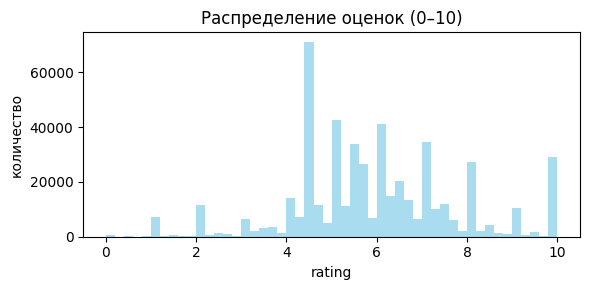

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(df_items['rating'], bins=50, alpha=0.7, color='skyblue')
plt.title('Распределение оценок (0–10)')
plt.xlabel('rating')
plt.ylabel('количество')
plt.tight_layout(); plt.show()

In [33]:
top_items = df_items[df_items['rating'] == 10.0][['item_id', 'name', 'media_type']]
top_items.head()

,item_id,name,media_type
29290,m_495686,What's New Scooby-Doo? Vol. 4: Merry Scary Hol...,movie
29393,m_392622,"What's New, Scooby-Doo? Vol. 7: Ready to Scare",movie
31914,m_609737,The 1st 13th Annual Fancy Anvil Awards Show Pr...,movie
39402,m_571278,Scooby-Doo's Original Mysteries,movie
44605,m_638443,"Scooby-Doo: Agence toutou risques, vol. 1 : Le...",movie


In [34]:
count_10 = df_items[df_items['rating'] == 10.0].shape[0]
print("Всего 10-балльных записей:", count_10)

Всего 10-балльных записей: 29005


In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.5, 5.0))
df_items['rating_scaled'] = scaler.fit_transform(df_items[['rating']]).ravel()

In [36]:
df_items['rating_scaled'].describe()

count    509628.000000
mean          3.150603
std           0.845719
min           0.500000
25%           2.525000
50%           3.065000
75%           3.650000
max           5.000000
Name: rating_scaled, dtype: float64

In [37]:
df_items = df_items.drop(columns=['rating'])

In [38]:
df_items['is_generated'] = df_items['is_generated'].astype(int)

In [39]:
df_items.head()

,item_id,name,description,genres,is_generated,media_type,release_year,decade,rating_scaled
0,m_27205,Inception,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",0,movie,2010.0,2010.0,4.26380
1,m_157336,Interstellar,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",0,movie,2014.0,2010.0,4.28765
2,m_155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",0,movie,2008.0,2000.0,4.33040
3,m_19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",0,movie,2009.0,2000.0,3.90785
4,m_24428,The Avengers,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",0,movie,2012.0,2010.0,3.96950


In [40]:
df_tv_shows_clean['vote_count'].describe()

count    164698.000000
mean         13.621720
std         193.067356
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       21857.000000
Name: vote_count, dtype: float64

In [41]:
df_movies_clean['vote_count'].describe()

count    344930.000000
mean         62.123486
std         575.859425
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max       34495.000000
Name: vote_count, dtype: float64

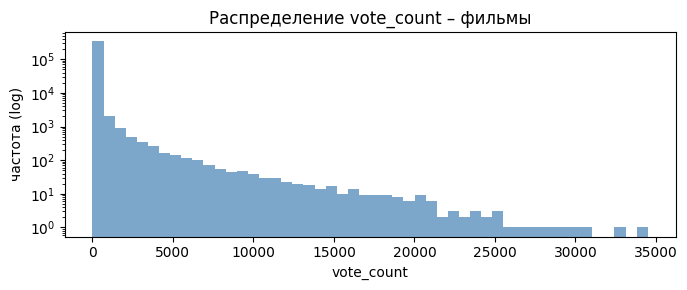

In [42]:
plt.figure(figsize=(7,3))
plt.hist(df_movies_clean['vote_count'], bins=50, color='steelblue', alpha=0.7)
plt.yscale('log')
plt.title('Распределение vote_count – фильмы')
plt.xlabel('vote_count')
plt.ylabel('частота (log)')
plt.tight_layout()
plt.show()

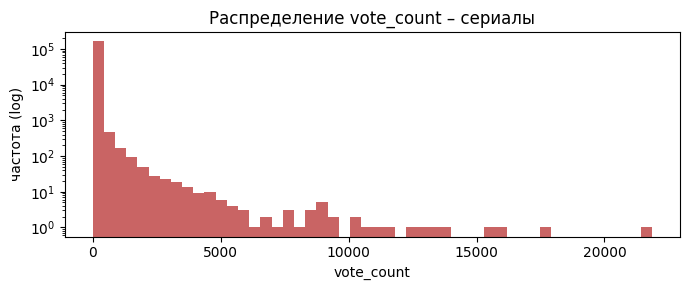

In [43]:
plt.figure(figsize=(7,3))
plt.hist(df_tv_shows_clean['vote_count'], bins=50, color='firebrick', alpha=0.7)
plt.yscale('log')
plt.title('Распределение vote_count – сериалы')
plt.xlabel('vote_count')
plt.ylabel('частота (log)')
plt.tight_layout()
plt.show()

In [44]:
bins_movies = [0, 100, 300, 500]
labels_movies = ['0–99', '100–299', '300–499']
movies_counts = pd.cut(df_movies_clean['vote_count'],
                       bins=bins_movies,
                       labels=labels_movies,
                       right=False).value_counts()
print("Фильмы:")
print(movies_counts)


Фильмы:
vote_count
0–99       326753
100–299      9191
300–499      2559
Name: count, dtype: int64


In [45]:
bins_tv = [0, 100, 300, 500]
labels_tv = ['0–99', '100–299', '300–499']
tv_counts = pd.cut(df_tv_shows_clean['vote_count'],
                    bins=bins_tv,
                    labels=labels_tv,
                    right=False).value_counts()
print("\nСериалы:")
print(tv_counts)


Сериалы:
vote_count
0–99       161668
100–299      1733
300–499       455
Name: count, dtype: int64


In [46]:
df_items.to_csv('df_items_final.csv', index=False, encoding='utf-8')